# Setup for Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [2]:
# project step 1
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import pandas as pd
import numpy as np

# project step 2
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from plotly.subplots import make_subplots
from xgboost import XGBClassifier
import plotly.graph_objs as gov
import plotly.offline as pyo
from sklearn.svm import SVC
import plotly.express as px
import pickle

# project step 3

# Read in data

In [3]:
# for running locally
# df = pd.read_csv('./Fraud.csv')

# for running on google colab
path = '/content/drive/MyDrive/Colab Notebooks/proj/Fraud.csv'
df = pd.read_csv(path)

In [4]:
#Transforming Type variable to numeric
type_to_num = {'PAYMENT' : 0,
               'TRANSFER' : 1,
               'CASH_OUT' : 2,
               'DEBIT' : 3,
               'CASH_IN' : 4}
df['type'] = df['type'].map(type_to_num)

#Renaming Columns for easier use of variables
df.rename(columns={'oldbalanceOrg' : 'oldBalanceOrig',
                   'newbalanceOrig' : 'newBalanceOrig',
                   'oldbalanceDest' : 'oldBalanceDest',
                   'newbalanceDest' : 'newBalanceDest'}, inplace=True)

In [5]:
# sanity check

print(df['type'].unique())
print(df.head(5))
print(df.dtypes)

[0 1 2 3 4]
   step  type    amount     nameOrig  oldBalanceOrig  newBalanceOrig  \
0     1     0   9839.64  C1231006815        170136.0       160296.36   
1     1     0   1864.28  C1666544295         21249.0        19384.72   
2     1     1    181.00  C1305486145           181.0            0.00   
3     1     2    181.00   C840083671           181.0            0.00   
4     1     0  11668.14  C2048537720         41554.0        29885.86   

      nameDest  oldBalanceDest  newBalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
step                int64
type                int64
amount            float64
nameOrig           object
oldBala

# Down sample and Rebalance

In [6]:
# separate df into 2 dfs based on target var
isFraud = df[df['isFraud'] == 1]
notFraud = df[df['isFraud'] == 0]

# random sample non-fraud w/ 10x the number of rows as fraud
resampled_df = notFraud.sample(n=10 * len(isFraud), random_state=1859)

# concat the 2 dfs together
balanced_df = pd.concat([isFraud, resampled_df])

# sanity check
print(balanced_df['isFraud'].value_counts())

0    82130
1     8213
Name: isFraud, dtype: int64


# Train-Test Split

In [7]:
X = balanced_df.drop(columns=['nameOrig', 'nameDest','isFraud', 'isFlaggedFraud'])
y = balanced_df['isFraud']

# train-test 70-30 split (since heavily imbalanced)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1859)

# Read in Model Pickle File

In [8]:
path = '/content/drive/MyDrive/Colab Notebooks/proj/proj_pickle.pkl'

with open(path, 'rb') as f:
    model = pickle.load(f)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[12:49:36] WARNING: /workspace/src/common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.




# Find Most Important Features

In [20]:
base_estimators = model.named_estimators_

# sanity check
print(base_estimators)

{'RF': RandomForestClassifier(), 'Bagging': BaggingClassifier(), 'GB': GradientBoostingClassifier(), 'XGB': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)}


Feature Importance for RF: [0.11120239 0.13097421 0.1969077  0.29324777 0.11123501 0.05953522
 0.09689769]
Feature Importance for Bagging: [0.06915992 0.04980219 0.28185503 0.4103685  0.11665939 0.00721022
 0.06494475]
Feature Importance for GB: [0.0572984  0.03389826 0.22101007 0.31463786 0.33342632 0.00054012
 0.03918897]
Feature Importance for XGB: [0.03221011 0.1214554  0.10476051 0.15547633 0.52871794 0.00521082
 0.05216885]
[0.0674677  0.08403252 0.20113333 0.29343262 0.27250967 0.0181241
 0.06330007]


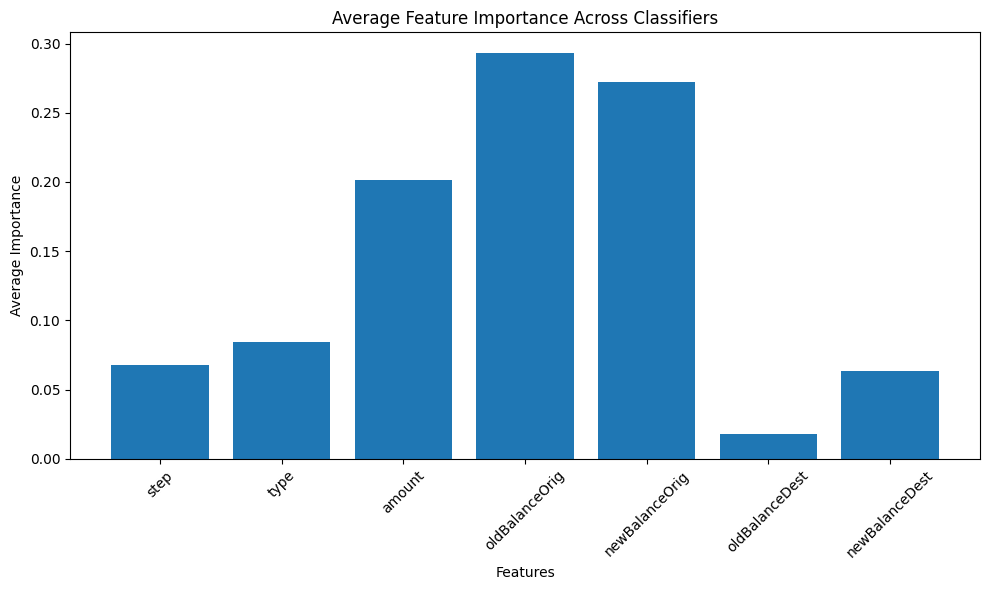

In [19]:
feature_importances = []

# get feature importance for each base estimator in the stacked model
for name, base_estimator in base_estimators.items():
    if isinstance(base_estimator, BaggingClassifier):
        feature_importance = np.mean([tree.feature_importances_ for tree in base_estimator.estimators_], axis=0)
    else:
        feature_importance = base_estimator.feature_importances_
    print(f"Feature Importance for {name}: {feature_importance}")

    feature_importances.append(feature_importance)

# take average of feature importances
average_importance = np.mean(feature_importances, axis=0)
print(average_importance)

# plot feature importance histogram
cols = X.columns
num_features = len(average_importance)

plt.figure(figsize=(10, 6))
plt.bar(range(num_features), average_importance)

plt.xlabel('Features')
plt.ylabel('Average Importance')
plt.title('Average Feature Importance Across Classifiers')

plt.xticks(range(num_features), cols, rotation=45)
plt.tight_layout()
plt.show();

Since `oldBalanceOrig` and `newBalanceOrig` have the highest average feature importance, we'll plot these features against the dependent variable, `isFraud`.

In [28]:
balanced_df['isFraud'] = balanced_df['isFraud'].map({0: 'False', 1: 'True'})

fig = px.box(balanced_df, x='isFraud', y='oldBalanceOrig', points="all")
fig.update_layout(
    title='Old Balance Origin Distribution by Fraud Status',
    xaxis_title='Fraud Status',
    yaxis_title='Old Balance Origin'
)
fig.show();

In [29]:
fig = px.box(balanced_df, x='isFraud', y='newBalanceOrig', points="all")
fig.update_layout(
    title='New Balance Origin Distribution by Fraud Status',
    xaxis_title='Fraud Status',
    yaxis_title='New Balance Origin'
)
fig.show();